In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [76]:
import tensorflow as tf
# print(tf.__version__)
# tf.config.experimental_run_functions_eagerly(True)

In [77]:
data = load_iris()

X = data.data 
y = data.target


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [79]:
def binary2int(key):
    if not isinstance(key, str):
        key = str(key)

    return int(key, 2)


In [80]:
def bit_length(number):
    if not isinstance(number, int):
        number = int(number)

    return (number).bit_length()


In [81]:
def max_value(dic):
    max_key = max(dic, key=dic.get)

    max_value = dic[max_key]

    return max_key, max_value


In [82]:
def feature_map(inputs, bit_length_response):

    qReg = QuantumRegister(len(inputs))
    print(f"feature maps:{inputs}")
    
    cReg = ClassicalRegister(bit_length_response)
    qc = QuantumCircuit(qReg, cReg)
    
    for i, x in enumerate(inputs):
        qc.rx(x, i)
    
    qc.barrier()
    
    return qc, cReg


In [83]:
def variational_circuit(qc, theta, inputs):
    
    for i in range(len(inputs) - 1):
        qc.cx(i+1, i)
    
    qc.cx(0, len(inputs)-1)
    qc.barrier()
    
    for i in range(len(inputs)):
        qc.ry(theta[i], i)

    qc.barrier()

    return qc


In [84]:
def measure(qc, bit_length_response):
    for i in range(bit_length_response):
        qc.measure(i, c[i])

    return qc


In [85]:
class QuantumLayer(tf.keras.layers.Layer):
    def __init__(self, bit_length_response, shots=1E4, **kwargs):
        super(QuantumLayer, self).__init__(**kwargs)
        self.bit_length_response = bit_length_response
        self.shots = shots

    def build(self, input_shape):
        self.N = input_shape[-1]
        self.n_response = bit_length(self.bit_length_response) # self.bit_length_response
        self.theta = self.add_weight(name='theta', shape=(self.N,), initializer='random_normal', trainable=True)

    def call(self, inputs):
        if tf.executing_eagerly():
            inputs_np = inputs.numpy()[-1]
            theta_np = self.theta.numpy()

            qc, cReg = feature_map(inputs_np, self.bit_length_response)
            qc = variational_circuit(qc, theta_np, inputs_np)
    
            for i in range(self.bit_length_response):
                qc.measure(i, cReg[i])
    
            results = AerSimulator().run(qc, shots=self.shots, memory=True).result()
            counts = results.get_counts(qc)
    
            stats = {}
            for key, value in counts.items():
                stats[binary2int(key)] = value / self.shots
    
            max_key, max_v = max_value(stats)
    
            # print(f"Key: {max_key}")

            outputs = np.zeros((tf.shape(inputs)[0], self.N))  # Modificação para retornar um tensor bidimensional
            if not max_key >= self.N:
                outputs[0, max_key] = max_v
            
            outputs = tf.constant(outputs, dtype=tf.float32)

            # print(f"Outputs shape: {outputs.shape}")
            return outputs

        return inputs

    def get_config(self):
        config = super(QuantumLayer, self).get_config()
        config.update({
            'bit_length_response': self.bit_length_response,
            'shots': self.shots,
        })
        return config


In [86]:
N=4
model = tf.keras.Sequential([
    tf.keras.layers.Dense(N, activation=tf.nn.relu, input_shape=(4,), name="Dense_1"),
    QuantumLayer(N, name="QuantumLayer"),
    tf.keras.layers.Dense(N, activation='softmax', input_shape=(4,), name="Dense_2")
])
model.build()

In [87]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [88]:
epochs = 50

In [89]:
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/50
feature maps:[2.293648 0.       0.       5.446398]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2812 - loss: 1.3863feature maps:[3.5983224 0.        0.        8.1699   ]
feature maps:[3.2484655 0.        0.        9.029959 ]
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2899 - loss: 1.3860feature maps:[2.0496912 0.        0.        5.321566 ]
feature maps:[3.082666 0.       0.       8.218545]
feature maps:[2.9400663 0.        0.        7.3081255]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2811 - loss: 1.3859 - val_accuracy: 0.2895 - val_loss: 1.3845
Epoch 2/50
feature maps:[2.7591734 0.        0.        7.7621946]
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1875 - loss: 1.3845feature maps:[3.5696924 0.        0.        8.220199 ]
feature maps:[2.021357 0.       0.       5.020516]
feature maps:[2.7688885 0.        0.        7.183815 ]
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2489 - loss: 1.3841feature maps:[3.082666 0.       0.       8

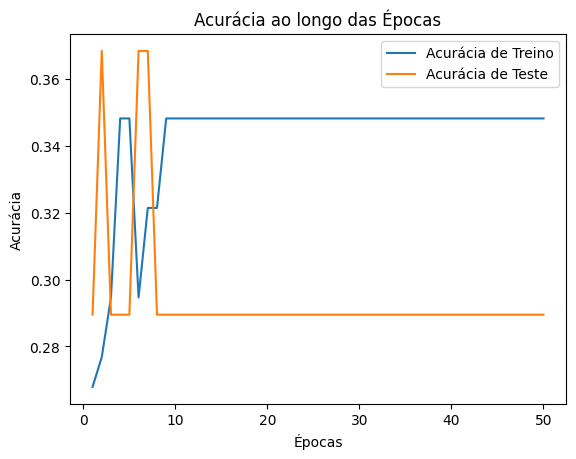

In [90]:
# Obtendo as métricas de acurácia do histórico
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Construindo o gráfico
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Acurácia de Treino')
plt.plot(range(1, len(test_accuracy) + 1), test_accuracy, label='Acurácia de Teste')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.title('Acurácia ao longo das Épocas')
plt.legend()
plt.show()
